In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.decomposition import FactorAnalysis
import seaborn as sns
from sklearn.utils import resample

# 1. Predicting Aggregate Measure with FA

Our aggregate measure of vascular risk is a discrete categorical variable. Therefore,
we considered that the optimal algorithm to predict it is a supervised learning model
for the classification of the aggregate measure, which values range from 0 to 5. In
addition, due to the imbalanced nature of our target variable, we considered that
the best algorithm to choose is Random Forest (RF) from the "ensemble" class in
Scikit-learn [1].

In [2]:
# Loading the data
data = pd.read_csv('casuality_data_final_factor_analyzer.csv')
data.shape

(2065, 1428)

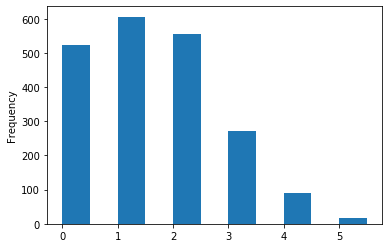

In [3]:
# Cardiovascular risk score
Y0 = data["agg_score"]
bin_values = np.arange(start=0, stop=6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [4]:
# Splitting each class from our target variable
S0 = data.loc[data['agg_score'] == 0]
S1 = data.loc[data['agg_score'] == 1]
S2 = data.loc[data['agg_score'] == 2]
S3 = data.loc[data['agg_score'] == 3]
S4 = data.loc[data['agg_score'] == 4]
S5 = data.loc[data['agg_score'] == 5]
S345 = pd.concat((S3, S4, S5), axis=0)
S0.shape, S1.shape, S2.shape, S3.shape, S4.shape, S5.shape, S345.shape

((523, 1428),
 (606, 1428),
 (555, 1428),
 (273, 1428),
 (91, 1428),
 (17, 1428),
 (381, 1428))

Random oversampling involves randomly duplicating examples from the minority
class and adding them to the training dataset. Examples from the training dataset are
selected randomly with replacement. This means that examples from the minority
class can be chosen and added to the new “more balanced” training dataset multiple
times.

In [5]:
# Oversample minority class
S0_over = resample(S0, replace=True, n_samples=606, random_state=123) 
S_0vs1 = pd.concat((S0_over, S1), axis=0)
S0_over2 = resample(S0, replace=True, n_samples=555, random_state=123)
S_0vs2 = pd.concat((S0_over2, S2), axis=0)
S3_over = resample(S3, replace=True, n_samples=523, random_state=123)
S_0vs3 = pd.concat((S0, S3_over), axis=0)
S4_over = resample(S4, replace=True, n_samples=523, random_state=123)
S_0vs4 = pd.concat((S0, S4_over), axis=0)
S5_over = resample(S5, replace=True, n_samples=523, random_state=123)
S_0vs5 = pd.concat((S0, S5_over), axis=0)
S345_over = resample(S345, replace=True, n_samples=523, random_state=123)
S_0vs345 = pd.concat((S0, S345_over), axis=0)
S_0vs1.shape, S_0vs2.shape, S_0vs3.shape, S_0vs4.shape, S_0vs5.shape, S_0vs345.shape 

((1212, 1428),
 (1110, 1428),
 (1046, 1428),
 (1046, 1428),
 (1046, 1428),
 (1046, 1428))

In [6]:
# Mapping values in binarized targets
S_0vs1["agg_score"] = S_0vs1["agg_score"].map({0:0, 1:1})
S_0vs2["agg_score"] = S_0vs2["agg_score"].map({0:0, 2:1})
S_0vs3["agg_score"] = S_0vs3["agg_score"].map({0:0, 3:1})
S_0vs4["agg_score"] = S_0vs4["agg_score"].map({0:0, 4:1})
S_0vs5["agg_score"] = S_0vs5["agg_score"].map({0:0, 5:1})
S_0vs345["agg_score"] = S_0vs345["agg_score"].map({0:0, 3:1, 4:1, 5:1})

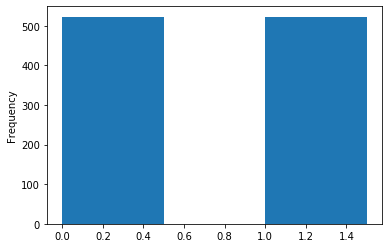

In [7]:
# Visualizing binary target class
Y0 = S_0vs5["agg_score"]
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [8]:
# Filtering data groups
heart_df = S_0vs5.filter(regex='heart')
cardio_cmr_df = S_0vs5.filter(regex='cardio_cmr')
brain_df = S_0vs5.filter(regex='brain')
heart_df.shape, brain_df.shape, cardio_cmr_df.shape

((1046, 630), (1046, 744), (1046, 9))

In [9]:
# our model
RF = RandomForestClassifier()

This popular technique consists of a combination of decision trees (DTs) trained on
different random samples of the training set. Each DT is a set of rules based on the
input features values optimized for accurately classifying all elements of the training
set. DTs are nonlinear models and tend to have high variance

## 1.1 Predicting aggregate measure of vascular risk with heart variables

In [10]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df

In [11]:
# Dimensionality reduction
factor_heart = FactorAnalysis(n_components=5)
X_heart_cfa = factor_heart.fit_transform(X1, Y0)
X_heart_cfa.shape

(1046, 5)

In [12]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_heart_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 5), (314, 5), (732,), (314,))

In [13]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9904458598726115

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       165
           1       0.98      1.00      0.99       149

    accuracy                           0.99       314
   macro avg       0.99      0.99      0.99       314
weighted avg       0.99      0.99      0.99       314



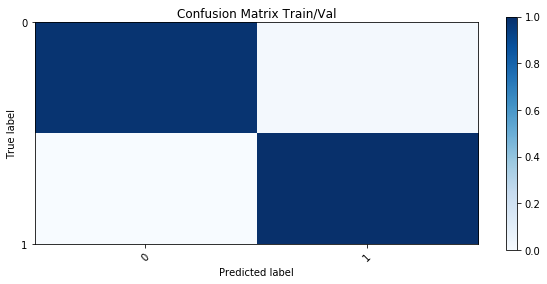

In [16]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [18]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [19]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [20]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

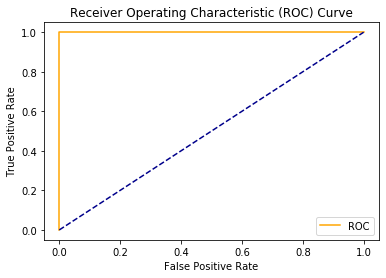

In [21]:
plot_roc_curve(fpr, tpr)

## 1.2 Predicting aggregate measure of vascular risk with CMR variables

In [22]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df

In [23]:
# Dimensionality reduction
factor_cardio = FactorAnalysis(n_components=5)
X_cmr_cfa = factor_cardio.fit_transform(X1, Y0)
X_cmr_cfa.shape

(1046, 5)

In [24]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_cmr_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 5), (314, 5), (732,), (314,))

In [25]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9808917197452229

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       165
           1       0.96      1.00      0.98       149

    accuracy                           0.98       314
   macro avg       0.98      0.98      0.98       314
weighted avg       0.98      0.98      0.98       314



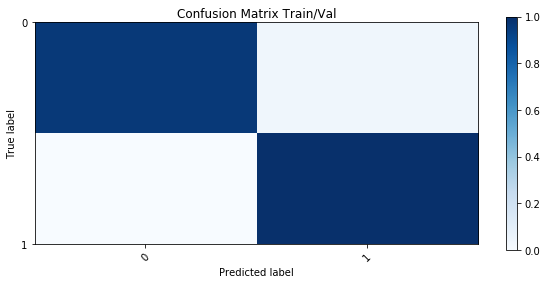

In [28]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [30]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [31]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [32]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

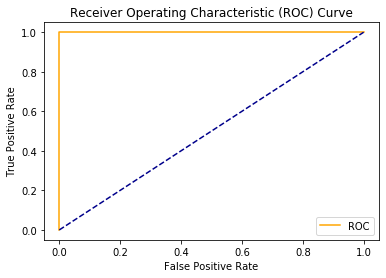

In [33]:
plot_roc_curve(fpr, tpr)

## 1.3 Predicting aggregate measure of vascular risk with brain variables

In [34]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = brain_df

In [35]:
# Dimensionality reduction
factor_brain = FactorAnalysis(n_components=5)
X_brain_cfa = factor_brain.fit_transform(X1, Y0)
X_brain_cfa.shape

(1046, 5)

In [36]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_brain_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 5), (314, 5), (732,), (314,))

In [37]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9968152866242038

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       165
           1       0.99      1.00      1.00       149

    accuracy                           1.00       314
   macro avg       1.00      1.00      1.00       314
weighted avg       1.00      1.00      1.00       314



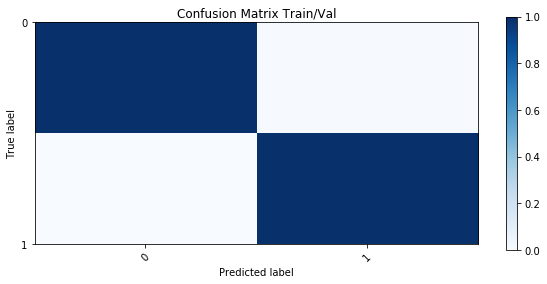

In [40]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [42]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [43]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

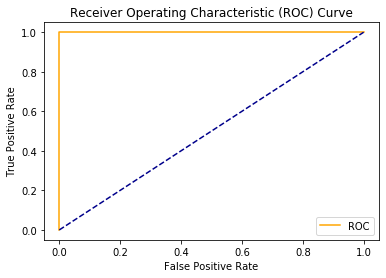

In [44]:
plot_roc_curve(fpr, tpr)

## 1.4 Predicting aggregate measure of vascular risk with heart/brain combinations

In [45]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df
X2 = brain_df
X1.shape, X2.shape

((1046, 630), (1046, 744))

In [46]:
# Combining datasets
X_combination_cfa = pd.concat((X1, X2), axis=1)
X_combination_cfa.shape

(1046, 1374)

In [47]:
# Dimensionality reduction
factor_1 = FactorAnalysis(n_components=5)
X__cfa_1 = factor_1.fit_transform(X_combination_cfa, Y0)
X__cfa_1.shape

(1046, 5)

In [48]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X__cfa_1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 5), (314, 5), (732,), (314,))

In [49]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9968152866242038

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       165
           1       0.99      1.00      1.00       149

    accuracy                           1.00       314
   macro avg       1.00      1.00      1.00       314
weighted avg       1.00      1.00      1.00       314



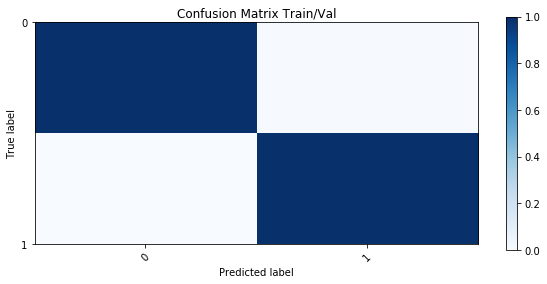

In [52]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [53]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [54]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [55]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

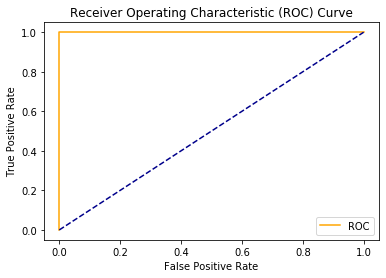

In [56]:
plot_roc_curve(fpr, tpr)

## 1.5 Predicting aggregate measure of vascular risk with CMR/brain combinations

In [57]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df
X2 = brain_df
X1.shape, X2.shape

((1046, 9), (1046, 744))

In [58]:
# Combining datasets
X_combination_cfa2 = pd.concat((X1, X2), axis=1)
X_combination_cfa2.shape

(1046, 753)

In [59]:
# Dimensionality reduction
factor_2 = FactorAnalysis(n_components=5)
X_cfa_2 = factor_2.fit_transform(X_combination_cfa2, Y0)
X_cfa_2.shape

(1046, 5)

In [60]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_cfa_2, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((732, 5), (314, 5), (732,), (314,))

In [61]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9968152866242038

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       165
           1       0.99      1.00      1.00       149

    accuracy                           1.00       314
   macro avg       1.00      1.00      1.00       314
weighted avg       1.00      1.00      1.00       314



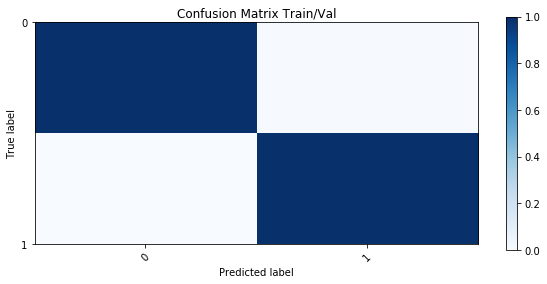

In [64]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [65]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [66]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 1.0000


In [67]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

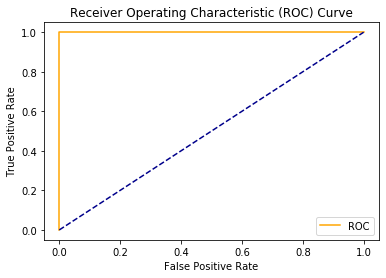

In [68]:
plot_roc_curve(fpr, tpr)

## 1.6 Correlation Plots

In [69]:
factor_heart.components_.shape, factor_cardio.components_.shape, factor_brain.components_.shape

((5, 630), (5, 9), (5, 744))

In [70]:
factor_1.components_.shape, factor_2.components_.shape

((5, 1374), (5, 753))

In [71]:
factor_heart_transposed = factor_heart.components_.T
factor_cardio_transposed = factor_cardio.components_.T
factor_brain_transposed = factor_brain.components_.T
factor_1_transposed = factor_1.components_.T
factor_2_transposed = factor_2.components_.T

In [72]:
factor_heart_transposed.shape, factor_cardio_transposed.shape, factor_brain_transposed.shape

((630, 5), (9, 5), (744, 5))

In [73]:
factor_1_transposed.shape, factor_2_transposed.shape

((1374, 5), (753, 5))

In [74]:
heart_components = pd.DataFrame(factor_heart_transposed, index=heart_df.columns)
cardio_components = pd.DataFrame(factor_cardio_transposed, index=cardio_cmr_df.columns)
brain_components = pd.DataFrame(factor_brain_transposed, index=brain_df.columns)
factor_1_components = pd.DataFrame(factor_1_transposed, index=X_combination_cfa.columns)
factor_2_components = pd.DataFrame(factor_2_transposed, index=X_combination_cfa2.columns)

In [75]:
#plt.figure(figsize=(16,9))
#sns.heatmap(heart_components,cmap=plt.cm.BrBG_r)
#plt.show()

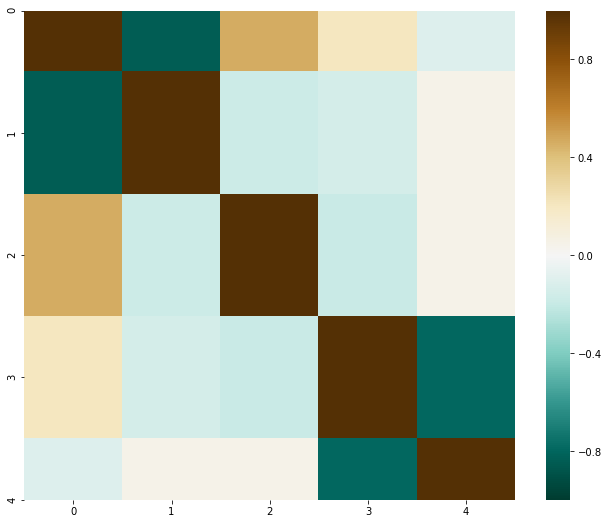

In [76]:
heart_corr = heart_components.corr()
plt.figure(figsize=(11,9))
sns.heatmap(heart_corr, cmap=plt.cm.BrBG_r, vmin=-1, vmax=1)
plt.show()

# 2. References

[1] [Pedregosa, F. et al. (2011)](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf). Scikit-learn: Machine Learning in Python.